In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from support_code.model2 import DQN
from support_code.env import TradingEnv
from support_code.functions import fetch_data, buy_and_hold, pickle_model, corr

In [2]:
import warnings
warnings.simplefilter('ignore')

---
---
---
### Random back testing

In [6]:
df = fetch_data('goog_df')

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance, actions=5)
env.verbose=1

In [7]:
np.random.seed(None)
env.seed(None)

In [8]:
done = False
obs = env.reset()
start = env.current_step

stock_performance = []
model_performance = []
actions = []

while not done:
    
    stock_performance.append(df.loc[env.current_step]['close'])
    model_performance.append(env.net_worth)
        
    action = np.random.randint(env.action_space.n)
    obs, rewards, done, info = env.step(action)

    actions.append(env._actions[action])
    
end = env.current_step

current price 926.5
action 0.0
balance 1000000 shares held 0
previous net worth 1000000 current net worth 1000000.0

current price 929.080017
action 0.5
total possible to buy 1075.2582993085718
number bought 537.6291496542859
cost of buying 499999.99999999994
balance 500000.00000000006 shares held 537.6291496542859
previous net worth 1000000.0 current net worth 999500.4995004996

current price 932.070007
action 0.0
balance 500000.00000000006 shares held 537.6291496542859
previous net worth 999500.4995004996 current net worth 1001108.0052816744

current price 935.090027
action 0.5
total possible to buy 534.1736999409786
number bought 267.0868499704893
cost of buying 250000.0
balance 250000.00000000006 shares held 804.7159996247752
previous net worth 1001108.0052816744 current net worth 1002481.905816463

current price 925.1099849999999
action 1.0
total possible to buy 269.9681700552068
number bought 269.9681700552068
cost of buying 250000.00000000003
balance 2.9103830456733704e-11 share

---

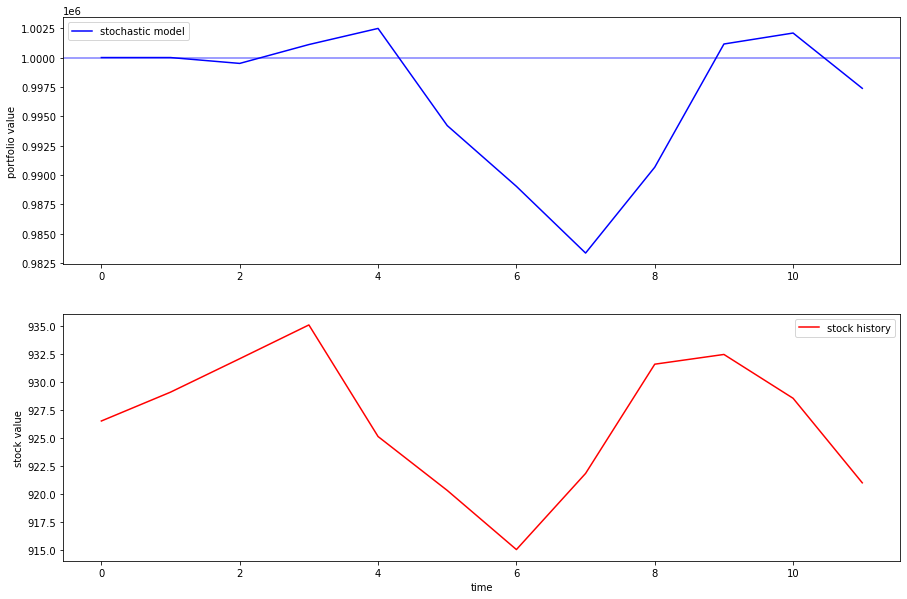

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(model_performance, 'b-', label='stochastic model')
ax1.set_ylabel('portfolio value')
ax1.axhline(starting_balance, alpha=0.5, color='blue')
ax1.legend()

ax2.plot(stock_performance, 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

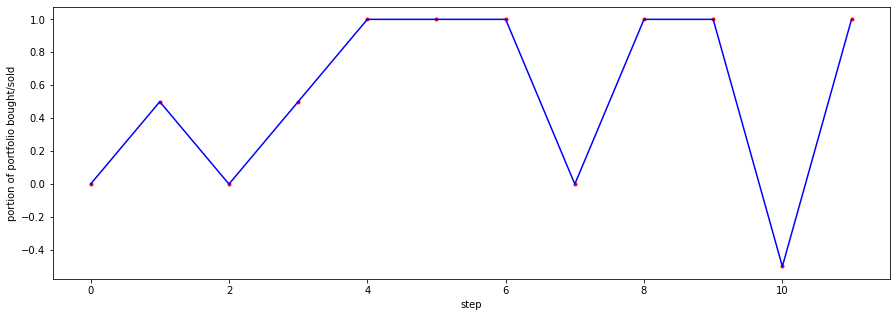

In [10]:
plt.figure(figsize=(15,5))
plt.plot(actions, 'r.')
plt.plot(actions, 'b-')
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')

plt.show();

In [11]:
corr(actions, stock_performance)

0.2578120490770921

---
---
---
### Training/backtesting

In [12]:
df = fetch_data('goog_df')
#df.shape

In [13]:
np.random.seed(None)

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance, actions=5)
env.verbose=0
env.seed(None)

#print(env.action_space, env.observation_space)

In [18]:
dqn_solver = DQN(
    action_space=env.action_space.n, 
    state_space=env.observation_space.shape,
    batch_size=64,
    memory_size=1_000_000,
    alpha=1.0,
    alpha_decay=0.999,
    alpha_min=0.1,
    gamma=0.99,
    )

dqn_solver.verbose = 0
dqn_solver.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 942)               29202     
_________________________________________________________________
dense_5 (Dense)              (None, 360)               339480    
_________________________________________________________________
dense_6 (Dense)              (None, 70)                25270     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 355       
Total params: 394,307
Trainable params: 394,307
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = []

In [38]:
for i in np.arange(1453, 2500):
    
    # Reset the evironment at the top of each episode
    state = env.reset()
    
    stock_performance = []
    model_performance = []
    reward_trace = []    
    actions = []
    
    start = env.current_step
    done = False    
    
    # The model will iterate until a terminal state is reached
    while not done:
                
        # Select an action by passing the current observation/state to the DQN
        action = dqn_solver.act(state)
        
        # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
        next_state, reward, done, info = env.step(action)
                
        # Commit to the DQN's memory the relevant information
        dqn_solver.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state

        actions.append(action)
        reward_trace.append(reward)
        model_performance.append(env.net_worth)  
        stock_performance.append(df.loc[env.current_step]['close'])
            
    print('================================================================================================================')
    print(i+1)
    print('FINAL PROFIT', env.net_worth-env.balance_init)
    print('MEAN REWARD:', np.mean(reward_trace))
    print('DAY RANGE:', start, env.current_step)
    print('EXPLORATION:', dqn_solver.alpha)
    print('MEMORY SIZE:', len(dqn_solver.memory))
    print('================================================================================================================')
    
    # After each episode, perform experience replay
    test = dqn_solver.replay()  
    
    print('\n\n\n')
    
    history.append({
        'stock': stock_performance,
        'model': model_performance,
        'actions': actions,
        'rewards': np.mean(reward_trace),
        })

X, y = test

1454
FINAL PROFIT 73604.1028694436
MEAN REWARD: -0.0007944788230145072
DAY RANGE: 814 933
EXPLORATION: 0.23486967737462733
MEMORY SIZE: 49545




1455
FINAL PROFIT 181135.2759030601
MEAN REWARD: -0.005432500899406755
DAY RANGE: 877 923
EXPLORATION: 0.2346348076972527
MEMORY SIZE: 49591




1456
FINAL PROFIT -28047.862847571727
MEAN REWARD: 0.003168013340879498
DAY RANGE: 1477 1536
EXPLORATION: 0.23440017288955545
MEMORY SIZE: 49650




1457
FINAL PROFIT -7796.31106982613
MEAN REWARD: 0.006053460046628802
DAY RANGE: 2115 2118
EXPLORATION: 0.2341657727166659
MEMORY SIZE: 49653




1458
FINAL PROFIT -11739.828340168926
MEAN REWARD: -0.0035500060917233955
DAY RANGE: 2163 2190
EXPLORATION: 0.2339316069439492
MEMORY SIZE: 49680




1459
FINAL PROFIT 30715.844369716942
MEAN REWARD: -0.03842975825602568
DAY RANGE: 1499 1537
EXPLORATION: 0.23369767533700525
MEMORY SIZE: 49718




1460
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1413 1414
EXPLORATION: 0.23346397766166824
MEMORY S





1477
FINAL PROFIT 29880.994870529743
MEAN REWARD: 0.00820381859534063
DAY RANGE: 1164 1191
EXPLORATION: 0.2295266829410795
MEMORY SIZE: 50395




1478
FINAL PROFIT 123463.42363524297
MEAN REWARD: -0.03101658179786871
DAY RANGE: 880 935
EXPLORATION: 0.22929715625813843
MEMORY SIZE: 50450




1479
FINAL PROFIT 334042.231500688
MEAN REWARD: -0.14603778807386716
DAY RANGE: 961 1238
EXPLORATION: 0.2290678591018803
MEMORY SIZE: 50727




1480
FINAL PROFIT -50717.307451698
MEAN REWARD: -0.004250574702000981
DAY RANGE: 530 568
EXPLORATION: 0.22883879124277842
MEMORY SIZE: 50765




1481
FINAL PROFIT 13754.442364716553
MEAN REWARD: -0.01859207148534207
DAY RANGE: 663 666
EXPLORATION: 0.22860995245153565
MEMORY SIZE: 50768




1482
FINAL PROFIT 16307.546366066206
MEAN REWARD: 0.07054538757978676
DAY RANGE: 1302 1410
EXPLORATION: 0.22838134249908412
MEMORY SIZE: 50876




1483
FINAL PROFIT 12238.586643380811
MEAN REWARD: -0.00975241938378345
DAY RANGE: 1113 1188
EXPLORATION: 0.228152961156585

1499
FINAL PROFIT 319905.7274053013
MEAN REWARD: -0.061343083894725293
DAY RANGE: 905 1139
EXPLORATION: 0.22452976478200387
MEMORY SIZE: 51875




1500
FINAL PROFIT 235857.34296934446
MEAN REWARD: -0.024557830422503653
DAY RANGE: 2081 2291
EXPLORATION: 0.22430523501722185
MEMORY SIZE: 52085




1501
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2182 2183
EXPLORATION: 0.22408092978220462
MEMORY SIZE: 52086




1502
FINAL PROFIT -179750.17490614904
MEAN REWARD: -0.00019425083245760868
DAY RANGE: 236 361
EXPLORATION: 0.2238568488524224
MEMORY SIZE: 52211




1503
FINAL PROFIT -8792.264214524417
MEAN REWARD: 0.003721970616429765
DAY RANGE: 2159 2169
EXPLORATION: 0.22363299200356998
MEMORY SIZE: 52221




1504
FINAL PROFIT 39985.345314435195
MEAN REWARD: -0.049462837569696945
DAY RANGE: 1888 1989
EXPLORATION: 0.22340935901156642
MEMORY SIZE: 52322




1505
FINAL PROFIT -8612.198285354883
MEAN REWARD: -0.0020589162391689312
DAY RANGE: 1663 1667
EXPLORATION: 0.22318594965255484






1522
FINAL PROFIT -195568.93656883982
MEAN REWARD: -0.026270986609929544
DAY RANGE: 229 404
EXPLORATION: 0.21942199056097256
MEMORY SIZE: 53375




1523
FINAL PROFIT -138586.02211863094
MEAN REWARD: -0.019952340643776968
DAY RANGE: 649 684
EXPLORATION: 0.2192025685704116
MEMORY SIZE: 53410




1524
FINAL PROFIT 36868.44525101257
MEAN REWARD: 0.011512782258680326
DAY RANGE: 719 741
EXPLORATION: 0.21898336600184118
MEMORY SIZE: 53432




1525
FINAL PROFIT 35217.98452126107
MEAN REWARD: 0.014176249229106819
DAY RANGE: 1501 1513
EXPLORATION: 0.21876438263583933
MEMORY SIZE: 53444




1526
FINAL PROFIT 64371.136279693805
MEAN REWARD: 0.0012931868227978442
DAY RANGE: 476 539
EXPLORATION: 0.21854561825320348
MEMORY SIZE: 53507




1527
FINAL PROFIT 11726.022672132822
MEAN REWARD: -0.05868155756052383
DAY RANGE: 395 637
EXPLORATION: 0.21832707263495027
MEMORY SIZE: 53749




1528
FINAL PROFIT 62921.88091278309
MEAN REWARD: 0.01360660997715464
DAY RANGE: 355 441
EXPLORATION: 0.2181087455623





1544
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 45 46
EXPLORATION: 0.2146450569378952
MEMORY SIZE: 54674




1545
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 733 734
EXPLORATION: 0.21443041188095732
MEMORY SIZE: 54675




1546
FINAL PROFIT 166439.74459438096
MEAN REWARD: 0.0006336967138205336
DAY RANGE: 2211 2280
EXPLORATION: 0.21421598146907636
MEMORY SIZE: 54744




1547
FINAL PROFIT 72675.66078422708
MEAN REWARD: -0.029124507421448724
DAY RANGE: 1229 1382
EXPLORATION: 0.21400176548760727
MEMORY SIZE: 54897




1548
FINAL PROFIT 4327.860840935493
MEAN REWARD: -0.003065677565890699
DAY RANGE: 577 609
EXPLORATION: 0.21378776372211966
MEMORY SIZE: 54929




1549
FINAL PROFIT -7806.055436562514
MEAN REWARD: -0.008054079406176461
DAY RANGE: 2183 2187
EXPLORATION: 0.21357397595839755
MEMORY SIZE: 54933




1550
FINAL PROFIT -138709.6810070395
MEAN REWARD: -0.057260472744137716
DAY RANGE: 1228 1503
EXPLORATION: 0.21336040198243916
MEMORY SIZE: 55208










1567
FINAL PROFIT 86982.60376888467
MEAN REWARD: -0.01146876126649222
DAY RANGE: 980 1016
EXPLORATION: 0.20976214758481407
MEMORY SIZE: 56252




1568
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2266 2267
EXPLORATION: 0.20955238543722926
MEMORY SIZE: 56253




1569
FINAL PROFIT 193182.3818717897
MEAN REWARD: -0.017407694138500324
DAY RANGE: 405 502
EXPLORATION: 0.20934283305179202
MEMORY SIZE: 56350




1570
FINAL PROFIT -78354.04111070547
MEAN REWARD: -0.00905395028560556
DAY RANGE: 535 747
EXPLORATION: 0.20913349021874023
MEMORY SIZE: 56562




1571
FINAL PROFIT 193031.2114833824
MEAN REWARD: -0.021247252987707698
DAY RANGE: 189 240
EXPLORATION: 0.2089243567285215
MEMORY SIZE: 56613




1572
FINAL PROFIT -59247.65190427343
MEAN REWARD: -0.005033644775011307
DAY RANGE: 236 303
EXPLORATION: 0.20871543237179296
MEMORY SIZE: 56680




1573
FINAL PROFIT 178447.47590880073
MEAN REWARD: -0.015821383470953167
DAY RANGE: 1600 1658
EXPLORATION: 0.20850671693942116
MEMORY SI





1590
FINAL PROFIT 20890.575417848886
MEAN REWARD: -0.0025765163194337378
DAY RANGE: 581 594
EXPLORATION: 0.20499031837534562
MEMORY SIZE: 57933




1591
FINAL PROFIT 47227.26911531994
MEAN REWARD: -0.012433131853035862
DAY RANGE: 1212 1251
EXPLORATION: 0.20478532805697028
MEMORY SIZE: 57972




1592
FINAL PROFIT 175987.24502240843
MEAN REWARD: -0.023724279033799908
DAY RANGE: 411 484
EXPLORATION: 0.2045805427289133
MEMORY SIZE: 58045




1593
FINAL PROFIT 63298.18785847607
MEAN REWARD: -0.003347832635360315
DAY RANGE: 899 920
EXPLORATION: 0.20437596218618437
MEMORY SIZE: 58066




1594
FINAL PROFIT -999.0009990008548
MEAN REWARD: -0.0023696810698704794
DAY RANGE: 764 766
EXPLORATION: 0.2041715862239982
MEMORY SIZE: 58068




1595
FINAL PROFIT -43206.89773001708
MEAN REWARD: -0.020590335856963075
DAY RANGE: 337 386
EXPLORATION: 0.2039674146377742
MEMORY SIZE: 58117




1596
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2091 2092
EXPLORATION: 0.20376344722313644
MEMORY 





1613
FINAL PROFIT -9978.838162193308
MEAN REWARD: 0.016848612986020722
DAY RANGE: 1820 1868
EXPLORATION: 0.20032704237371998
MEMORY SIZE: 59134




1614
FINAL PROFIT 162525.6572561143
MEAN REWARD: -0.035814338203624604
DAY RANGE: 2068 2234
EXPLORATION: 0.20012671533134627
MEMORY SIZE: 59300




1615
FINAL PROFIT 38737.19443636178
MEAN REWARD: -0.0018118260621257445
DAY RANGE: 1534 1562
EXPLORATION: 0.19992658861601492
MEMORY SIZE: 59328




1616
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2126 2127
EXPLORATION: 0.19972666202739892
MEMORY SIZE: 59329




1617
FINAL PROFIT 166939.6489195719
MEAN REWARD: -0.019340714564194658
DAY RANGE: 186 244
EXPLORATION: 0.19952693536537153
MEMORY SIZE: 59387




1618
FINAL PROFIT 7106.330845493358
MEAN REWARD: 0.005922888083625029
DAY RANGE: 1109 1168
EXPLORATION: 0.19932740843000615
MEMORY SIZE: 59446




1619
FINAL PROFIT 47424.15105680097
MEAN REWARD: -0.019630199886497227
DAY RANGE: 598 655
EXPLORATION: 0.19912808102157614
MEMO





1635
FINAL PROFIT -3175.129962555133
MEAN REWARD: 0.003683173526576091
DAY RANGE: 463 537
EXPLORATION: 0.19596581594477305
MEMORY SIZE: 60094




1636
FINAL PROFIT 22793.06764296675
MEAN REWARD: -0.011611439628858225
DAY RANGE: 2192 2204
EXPLORATION: 0.19576985012882828
MEMORY SIZE: 60106




1637
FINAL PROFIT -59235.843069260474
MEAN REWARD: -0.008871580487767159
DAY RANGE: 1446 1487
EXPLORATION: 0.19557408027869944
MEMORY SIZE: 60147




1638
FINAL PROFIT 46382.467791008996
MEAN REWARD: -0.00587826871204882
DAY RANGE: 1213 1250
EXPLORATION: 0.19537850619842073
MEMORY SIZE: 60184




1639
FINAL PROFIT 19684.321714224294
MEAN REWARD: 0.006567724018346053
DAY RANGE: 215 217
EXPLORATION: 0.19518312769222232
MEMORY SIZE: 60186




1640
FINAL PROFIT -53891.53634869261
MEAN REWARD: 0.009339109899566466
DAY RANGE: 794 882
EXPLORATION: 0.19498794456453009
MEMORY SIZE: 60274




1641
FINAL PROFIT 62845.03953394317
MEAN REWARD: 0.09608041406980584
DAY RANGE: 2315 2356
EXPLORATION: 0.1947929





1658
FINAL PROFIT -115743.85774497944
MEAN REWARD: -0.00025196348140763057
DAY RANGE: 1290 1334
EXPLORATION: 0.19150783620272022
MEMORY SIZE: 61078




1659
FINAL PROFIT -15238.379658296355
MEAN REWARD: 0.01361397250907112
DAY RANGE: 1858 1880
EXPLORATION: 0.1913163283665175
MEMORY SIZE: 61100




1660
FINAL PROFIT -37288.43714265968
MEAN REWARD: -0.01493057724113948
DAY RANGE: 593 637
EXPLORATION: 0.19112501203815097
MEMORY SIZE: 61144




1661
FINAL PROFIT 75819.25148029672
MEAN REWARD: 0.008656632824034954
DAY RANGE: 60 66
EXPLORATION: 0.1909338870261128
MEMORY SIZE: 61150




1662
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1144 1145
EXPLORATION: 0.19074295313908668
MEMORY SIZE: 61151




1663
FINAL PROFIT 51085.569438607665
MEAN REWARD: -0.08398727175178469
DAY RANGE: 11 16
EXPLORATION: 0.1905522101859476
MEMORY SIZE: 61156




1664
FINAL PROFIT -90946.73680240056
MEAN REWARD: 0.0017665597315617296
DAY RANGE: 535 571
EXPLORATION: 0.19036165797576166
MEMORY SIZE





1681
FINAL PROFIT 7961.127534032334
MEAN REWARD: -0.03200668511947568
DAY RANGE: 393 669
EXPLORATION: 0.18715126998161608
MEMORY SIZE: 62207




1682
FINAL PROFIT 239963.5140129258
MEAN REWARD: -0.02381748196581203
DAY RANGE: 157 316
EXPLORATION: 0.18696411871163446
MEMORY SIZE: 62366




1683
FINAL PROFIT 45926.53271004162
MEAN REWARD: 0.0004927928555571107
DAY RANGE: 2228 2356
EXPLORATION: 0.18677715459292282
MEMORY SIZE: 62494




1684
FINAL PROFIT 39511.5202045124
MEAN REWARD: -0.015187239575493339
DAY RANGE: 2022 2095
EXPLORATION: 0.1865903774383299
MEMORY SIZE: 62567




1685
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 152 153
EXPLORATION: 0.18640378706089158
MEMORY SIZE: 62568




1686
FINAL PROFIT -37690.11481931573
MEAN REWARD: 0.005867789698382022
DAY RANGE: 1132 1175
EXPLORATION: 0.1862173832738307
MEMORY SIZE: 62611




1687
FINAL PROFIT 294806.906925136
MEAN REWARD: -0.036209613861117415
DAY RANGE: 916 1105
EXPLORATION: 0.18603116589055688
MEMORY SIZE: 





1704
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0018826432291972452
DAY RANGE: 2125 2127
EXPLORATION: 0.182893810249391
MEMORY SIZE: 64931




1705
FINAL PROFIT 385736.05437977845
MEAN REWARD: 0.031901800917003904
DAY RANGE: 603 1027
EXPLORATION: 0.1827109164391416
MEMORY SIZE: 65355




1706
FINAL PROFIT 358636.2999677621
MEAN REWARD: -0.05938577310978087
DAY RANGE: 91 227
EXPLORATION: 0.18252820552270246
MEMORY SIZE: 65491




1707
FINAL PROFIT 72458.29615012789
MEAN REWARD: -0.004650020159248019
DAY RANGE: 1329 1403
EXPLORATION: 0.18234567731717977
MEMORY SIZE: 65565




1708
FINAL PROFIT -99962.54252542951
MEAN REWARD: -0.006173181969942797
DAY RANGE: 1764 1791
EXPLORATION: 0.1821633316398626
MEMORY SIZE: 65592




1709
FINAL PROFIT -2858.025050802622
MEAN REWARD: -0.0031047365487356935
DAY RANGE: 1148 1186
EXPLORATION: 0.18198116830822272
MEMORY SIZE: 65630




1710
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1952 1953
EXPLORATION: 0.1817991871399145
MEMORY





1727
FINAL PROFIT -19445.69130035292
MEAN REWARD: -1.1114273493908433e-05
DAY RANGE: 268 279
EXPLORATION: 0.17873320245609906
MEMORY SIZE: 66744




1728
FINAL PROFIT 109436.54983806005
MEAN REWARD: -0.014066525101859684
DAY RANGE: 632 647
EXPLORATION: 0.17855446925364296
MEMORY SIZE: 66759




1729
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 833 834
EXPLORATION: 0.17837591478438933
MEMORY SIZE: 66760




1730
FINAL PROFIT -69956.72060077765
MEAN REWARD: -0.029912925350598786
DAY RANGE: 1675 1701
EXPLORATION: 0.17819753886960493
MEMORY SIZE: 66786




1731
FINAL PROFIT 9555.20458558842
MEAN REWARD: -0.0019262325047356618
DAY RANGE: 1427 1430
EXPLORATION: 0.17801934133073533
MEMORY SIZE: 66789




1732
FINAL PROFIT -84949.28638455737
MEAN REWARD: -0.00393112993388454
DAY RANGE: 222 279
EXPLORATION: 0.17784132198940458
MEMORY SIZE: 66846




1733
FINAL PROFIT 43415.2429480023
MEAN REWARD: -0.03347507153870346
DAY RANGE: 608 729
EXPLORATION: 0.1776634806674152
MEMORY S





1750
FINAL PROFIT 16589.00196189247
MEAN REWARD: 0.015964628838722742
DAY RANGE: 1333 1356
EXPLORATION: 0.17466724334001496
MEMORY SIZE: 68190




1751
FINAL PROFIT -110450.57090425107
MEAN REWARD: -0.004541157314033153
DAY RANGE: 1284 1342
EXPLORATION: 0.17449257609667496
MEMORY SIZE: 68248




1752
FINAL PROFIT -68450.67248846311
MEAN REWARD: 0.010525570430733426
DAY RANGE: 813 840
EXPLORATION: 0.1743180835205783
MEMORY SIZE: 68275




1753
FINAL PROFIT -22714.80604548729
MEAN REWARD: -0.013400663244313464
DAY RANGE: 205 294
EXPLORATION: 0.1741437654370577
MEMORY SIZE: 68364




1754
FINAL PROFIT 135649.9908330487
MEAN REWARD: -0.029628976475827757
DAY RANGE: 609 646
EXPLORATION: 0.17396962167162064
MEMORY SIZE: 68401




1755
FINAL PROFIT -12361.686869533034
MEAN REWARD: 0.0038804339401592243
DAY RANGE: 459 544
EXPLORATION: 0.173795652049949
MEMORY SIZE: 68486




1756
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 924 925
EXPLORATION: 0.17362185639789907
MEMORY SIZ





1772
FINAL PROFIT 25302.146589380107
MEAN REWARD: -0.002339599910444577
DAY RANGE: 1476 1557
EXPLORATION: 0.17086464440529564
MEMORY SIZE: 69787




1773
FINAL PROFIT -59339.75974451704
MEAN REWARD: 0.019134830120741523
DAY RANGE: 535 585
EXPLORATION: 0.17069377976089034
MEMORY SIZE: 69837




1774
FINAL PROFIT 14184.558626550599
MEAN REWARD: -0.017889448244090878
DAY RANGE: 1835 1922
EXPLORATION: 0.17052308598112945
MEMORY SIZE: 69924




1775
FINAL PROFIT 44183.22929951467
MEAN REWARD: 0.01153585361349791
DAY RANGE: 1344 1504
EXPLORATION: 0.17035256289514833
MEMORY SIZE: 70084




1776
FINAL PROFIT -27611.621320334263
MEAN REWARD: 0.0017125788793804241
DAY RANGE: 1475 1485
EXPLORATION: 0.17018221033225317
MEMORY SIZE: 70094




1777
FINAL PROFIT 100433.35208985396
MEAN REWARD: -0.015106823485905896
DAY RANGE: 657 826
EXPLORATION: 0.17001202812192093
MEMORY SIZE: 70263




1778
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2233 2234
EXPLORATION: 0.169842016093799
MEM





1795
FINAL PROFIT 21042.85195066617
MEAN REWARD: -0.006295555036234427
DAY RANGE: 1124 1137
EXPLORATION: 0.1669776852449974
MEMORY SIZE: 71859




1796
FINAL PROFIT 25051.38675036293
MEAN REWARD: -0.06852566226618559
DAY RANGE: 2062 2154
EXPLORATION: 0.1668107075597524
MEMORY SIZE: 71951




1797
FINAL PROFIT -54554.98284498474
MEAN REWARD: -0.04155756962426872
DAY RANGE: 266 329
EXPLORATION: 0.16664389685219266
MEMORY SIZE: 72014




1798
FINAL PROFIT 263178.2481748285
MEAN REWARD: -0.03980785831719952
DAY RANGE: 1168 1342
EXPLORATION: 0.16647725295534047
MEMORY SIZE: 72188




1799
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1395 1396
EXPLORATION: 0.16631077570238512
MEMORY SIZE: 72189




1800
FINAL PROFIT -28989.171058241744
MEAN REWARD: 0.008372785990223133
DAY RANGE: 456 477
EXPLORATION: 0.16614446492668272
MEMORY SIZE: 72210




1801
FINAL PROFIT 371888.3470268892
MEAN REWARD: 0.011221818469040128
DAY RANGE: 131 299
EXPLORATION: 0.16597832046175603
MEMORY SIZ





1818
FINAL PROFIT -18303.178959343582
MEAN REWARD: -0.001447921487565027
DAY RANGE: 644 740
EXPLORATION: 0.16317914959423443
MEMORY SIZE: 73879




1819
FINAL PROFIT -125069.45625425619
MEAN REWARD: 0.005732094747846324
DAY RANGE: 253 268
EXPLORATION: 0.1630159704446402
MEMORY SIZE: 73894




1820
FINAL PROFIT -4836.7757903644815
MEAN REWARD: 0.004425189018177612
DAY RANGE: 2159 2180
EXPLORATION: 0.16285295447419557
MEMORY SIZE: 73915




1821
FINAL PROFIT 56539.290040971246
MEAN REWARD: -0.0025897871254077667
DAY RANGE: 272 303
EXPLORATION: 0.16269010151972138
MEMORY SIZE: 73946




1822
FINAL PROFIT 233875.99365743902
MEAN REWARD: 0.008142420057317287
DAY RANGE: 815 1086
EXPLORATION: 0.16252741141820165
MEMORY SIZE: 74217




1823
FINAL PROFIT 142151.21104187146
MEAN REWARD: -0.006074625004630967
DAY RANGE: 2035 2168
EXPLORATION: 0.16236488400678345
MEMORY SIZE: 74350




1824
FINAL PROFIT -113357.40111648827
MEAN REWARD: 0.055835456366624056
DAY RANGE: 514 582
EXPLORATION: 0.162





1841
FINAL PROFIT 22834.311355207814
MEAN REWARD: -0.02375553660372842
DAY RANGE: 874 885
EXPLORATION: 0.15946702592761744
MEMORY SIZE: 75115




1842
FINAL PROFIT -106664.62583532848
MEAN REWARD: -0.03268218785410675
DAY RANGE: 2304 2347
EXPLORATION: 0.15930755890168982
MEMORY SIZE: 75158




1843
FINAL PROFIT 20321.092682795017
MEAN REWARD: 0.007651325990827061
DAY RANGE: 1133 1156
EXPLORATION: 0.15914825134278812
MEMORY SIZE: 75181




1844
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2001 2002
EXPLORATION: 0.15898910309144534
MEMORY SIZE: 75182




1845
FINAL PROFIT 223970.90618951106
MEAN REWARD: -0.014841173887119545
DAY RANGE: 1156 1258
EXPLORATION: 0.1588301139883539
MEMORY SIZE: 75284




1846
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1778 1779
EXPLORATION: 0.15867128387436555
MEMORY SIZE: 75285




1847
FINAL PROFIT -4848.015233013197
MEAN REWARD: -0.005040147565885156
DAY RANGE: 2070 2072
EXPLORATION: 0.15851261259049118
MEMORY SIZE: 7528





1864
FINAL PROFIT 23462.984495425364
MEAN REWARD: -0.002272906155174569
DAY RANGE: 1129 1137
EXPLORATION: 0.15583934847946967
MEMORY SIZE: 77097




1865
FINAL PROFIT 3924.579774323851
MEAN REWARD: -0.004034883568247217
DAY RANGE: 438 444
EXPLORATION: 0.15568350913099022
MEMORY SIZE: 77103




1866
FINAL PROFIT -10453.523015052546
MEAN REWARD: 0.019890465315084267
DAY RANGE: 1325 1374
EXPLORATION: 0.15552782562185924
MEMORY SIZE: 77152




1867
FINAL PROFIT -5975.146730907145
MEAN REWARD: -0.04322786459702537
DAY RANGE: 1279 1287
EXPLORATION: 0.15537229779623737
MEMORY SIZE: 77160




1868
FINAL PROFIT -56014.32594068826
MEAN REWARD: -0.033466646523323144
DAY RANGE: 1838 1841
EXPLORATION: 0.15521692549844113
MEMORY SIZE: 77163




1869
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1108 1109
EXPLORATION: 0.15506170857294269
MEMORY SIZE: 77164




1870
FINAL PROFIT -22499.805403713835
MEAN REWARD: -0.0005261743380096984
DAY RANGE: 1917 1941
EXPLORATION: 0.15490664686436





1886
FINAL PROFIT 226199.10990252905
MEAN REWARD: 0.030876486633675274
DAY RANGE: 899 950
EXPLORATION: 0.15244664284569598
MEMORY SIZE: 77974




1887
FINAL PROFIT 10552.767536446685
MEAN REWARD: 0.006983460516767589
DAY RANGE: 1046 1065
EXPLORATION: 0.15229419620285028
MEMORY SIZE: 77993




1888
FINAL PROFIT 52972.209930824814
MEAN REWARD: -0.033029448526184585
DAY RANGE: 2220 2356
EXPLORATION: 0.15214190200664743
MEMORY SIZE: 78129




1889
FINAL PROFIT -78525.24441555655
MEAN REWARD: 0.03075726517716329
DAY RANGE: 361 380
EXPLORATION: 0.15198976010464077
MEMORY SIZE: 78148




1890
FINAL PROFIT 90856.43169112853
MEAN REWARD: -0.006809031952710668
DAY RANGE: 1339 1421
EXPLORATION: 0.15183777034453613
MEMORY SIZE: 78230




1891
FINAL PROFIT 16778.527480125427
MEAN REWARD: -0.014990545042789847
DAY RANGE: 396 404
EXPLORATION: 0.1516859325741916
MEMORY SIZE: 78238




1892
FINAL PROFIT 18971.308471029508
MEAN REWARD: -0.0006985639047494155
DAY RANGE: 1666 1789
EXPLORATION: 0.15153

1908
FINAL PROFIT 39419.513977899216
MEAN REWARD: -0.026416250943557797
DAY RANGE: 2051 2144
EXPLORATION: 0.14912779822090194
MEMORY SIZE: 79301




1909
FINAL PROFIT 3835.705370116746
MEAN REWARD: -0.038046534106886576
DAY RANGE: 347 360
EXPLORATION: 0.14897867042268104
MEMORY SIZE: 79314




1910
FINAL PROFIT 232499.82386291074
MEAN REWARD: 0.055119176828673885
DAY RANGE: 854 1020
EXPLORATION: 0.14882969175225835
MEMORY SIZE: 79480




1911
FINAL PROFIT 192939.4767841203
MEAN REWARD: 0.02295861118604949
DAY RANGE: 2003 2197
EXPLORATION: 0.1486808620605061
MEMORY SIZE: 79674




1912
FINAL PROFIT -58300.20297060325
MEAN REWARD: 0.003906276398841555
DAY RANGE: 1431 1470
EXPLORATION: 0.14853218119844558
MEMORY SIZE: 79713




1913
FINAL PROFIT -4407.413576029707
MEAN REWARD: 0.009232123870417934
DAY RANGE: 219 267
EXPLORATION: 0.14838364901724713
MEMORY SIZE: 79761




1914
FINAL PROFIT -11733.91968960641
MEAN REWARD: -0.02566326328309354
DAY RANGE: 879 882
EXPLORATION: 0.14823526536822





1931
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 156 157
EXPLORATION: 0.14573532540496414
MEMORY SIZE: 81313




1932
FINAL PROFIT 269574.26246354287
MEAN REWARD: -0.027450203281383447
DAY RANGE: 2075 2268
EXPLORATION: 0.14558959007955918
MEMORY SIZE: 81506




1933
FINAL PROFIT 89568.25888723275
MEAN REWARD: -0.0006707859918544735
DAY RANGE: 395 439
EXPLORATION: 0.1454440004894796
MEMORY SIZE: 81550




1934
FINAL PROFIT 340942.0896148286
MEAN REWARD: 0.008690950244265945
DAY RANGE: 1944 2264
EXPLORATION: 0.14529855648899012
MEMORY SIZE: 81870




1935
FINAL PROFIT 24108.12086915155
MEAN REWARD: -0.04232728449020169
DAY RANGE: 1882 1898
EXPLORATION: 0.14515325793250114
MEMORY SIZE: 81886




1936
FINAL PROFIT 313936.20077279303
MEAN REWARD: -0.017422202548996644
DAY RANGE: 1109 1310
EXPLORATION: 0.14500810467456865
MEMORY SIZE: 82087




1937
FINAL PROFIT 111357.5791224083
MEAN REWARD: 0.04500522126113899
DAY RANGE: 1686 1789
EXPLORATION: 0.14486309656989407
MEMORY





1954
FINAL PROFIT -17583.611486379406
MEAN REWARD: -0.012701246006874788
DAY RANGE: 228 299
EXPLORATION: 0.14242002714631322
MEMORY SIZE: 83248




1955
FINAL PROFIT -39942.0297116522
MEAN REWARD: -0.001447415413792284
DAY RANGE: 374 377
EXPLORATION: 0.1422776071191669
MEMORY SIZE: 83251




1956
FINAL PROFIT 1528881.9643985112
MEAN REWARD: -0.2205924224553732
DAY RANGE: 991 2251
EXPLORATION: 0.14213532951204774
MEMORY SIZE: 84511




1957
FINAL PROFIT -29737.40895900922
MEAN REWARD: -0.004615120441903594
DAY RANGE: 1881 1889
EXPLORATION: 0.1419931941825357
MEMORY SIZE: 84519




1958
FINAL PROFIT 93332.09326490737
MEAN REWARD: -0.02254058444346462
DAY RANGE: 55 97
EXPLORATION: 0.14185120098835316
MEMORY SIZE: 84561




1959
FINAL PROFIT 13408.654106959933
MEAN REWARD: -0.0010026980507160184
DAY RANGE: 962 968
EXPLORATION: 0.1417093497873648
MEMORY SIZE: 84567




1960
FINAL PROFIT -47368.677624565666
MEAN REWARD: -0.05369691401751025
DAY RANGE: 1838 1868
EXPLORATION: 0.14156764043





1977
FINAL PROFIT 29421.600186187425
MEAN REWARD: -0.023825762236211544
DAY RANGE: 860 898
EXPLORATION: 0.13918014781929933
MEMORY SIZE: 85641




1978
FINAL PROFIT -19555.30150957359
MEAN REWARD: -0.01156794878145847
DAY RANGE: 1304 1400
EXPLORATION: 0.13904096767148003
MEMORY SIZE: 85737




1979
FINAL PROFIT -52000.078769649495
MEAN REWARD: -0.033787612317632
DAY RANGE: 571 705
EXPLORATION: 0.13890192670380855
MEMORY SIZE: 85871




1980
FINAL PROFIT -2957.9760149981594
MEAN REWARD: -4.224811357671857e-05
DAY RANGE: 1592 1607
EXPLORATION: 0.13876302477710473
MEMORY SIZE: 85886




1981
FINAL PROFIT 240695.62044773553
MEAN REWARD: 0.011593146542266643
DAY RANGE: 989 1175
EXPLORATION: 0.13862426175232762
MEMORY SIZE: 86072




1982
FINAL PROFIT 11330.584664463066
MEAN REWARD: -0.0017898402297761365
DAY RANGE: 2189 2204
EXPLORATION: 0.1384856374905753
MEMORY SIZE: 86087




1983
FINAL PROFIT -721.1169773262227
MEAN REWARD: 0.018690875897446838
DAY RANGE: 1185 1196
EXPLORATION: 0.13





1999
FINAL PROFIT 191730.0005812524
MEAN REWARD: -0.0074547838547501435
DAY RANGE: 909 1037
EXPLORATION: 0.1361501218584413
MEMORY SIZE: 88242




2000
FINAL PROFIT -14953.504533149302
MEAN REWARD: -0.00956202760623212
DAY RANGE: 1808 1875
EXPLORATION: 0.13601397173658286
MEMORY SIZE: 88309




2001
FINAL PROFIT 390332.5707985547
MEAN REWARD: -0.0226959091875983
DAY RANGE: 86 304
EXPLORATION: 0.1358779577648463
MEMORY SIZE: 88527




2002
FINAL PROFIT 255751.47015876556
MEAN REWARD: 0.03129576508926469
DAY RANGE: 150 217
EXPLORATION: 0.13574207980708144
MEMORY SIZE: 88594




2003
FINAL PROFIT -3724.0384749063523
MEAN REWARD: 0.023875469252207304
DAY RANGE: 1668 1710
EXPLORATION: 0.13560633772727437
MEMORY SIZE: 88636




2004
FINAL PROFIT 151693.00033364515
MEAN REWARD: -0.25691350707782745
DAY RANGE: 995 1467
EXPLORATION: 0.1354707313895471
MEMORY SIZE: 89108




2005
FINAL PROFIT 138794.30077903904
MEAN REWARD: 0.00048291680327715883
DAY RANGE: 2168 2267
EXPLORATION: 0.135335260





2021
FINAL PROFIT 19847.330920844222
MEAN REWARD: -0.06236668803075685
DAY RANGE: 1239 1332
EXPLORATION: 0.13318606117688014
MEMORY SIZE: 90689




2022
FINAL PROFIT 30350.48204280692
MEAN REWARD: -0.029876601141231647
DAY RANGE: 2121 2356
EXPLORATION: 0.13305287511570327
MEMORY SIZE: 90924




2023
FINAL PROFIT -200368.406871884
MEAN REWARD: -0.020252734967514282
DAY RANGE: 567 624
EXPLORATION: 0.13291982224058757
MEMORY SIZE: 90981




2024
FINAL PROFIT -86271.04855565715
MEAN REWARD: -0.0017258512071763495
DAY RANGE: 234 294
EXPLORATION: 0.13278690241834698
MEMORY SIZE: 91041




2025
FINAL PROFIT 371790.4979311442
MEAN REWARD: -0.01567231708118721
DAY RANGE: 907 1142
EXPLORATION: 0.13265411551592862
MEMORY SIZE: 91276




2026
FINAL PROFIT 33202.35161117709
MEAN REWARD: 0.00041967995481227276
DAY RANGE: 2061 2095
EXPLORATION: 0.13252146140041268
MEMORY SIZE: 91310




2027
FINAL PROFIT -47047.4795433525
MEAN REWARD: -0.0006891605294327149
DAY RANGE: 1477 1513
EXPLORATION: 0.132





2043
FINAL PROFIT -173798.03436582861
MEAN REWARD: 0.014634898061248723
DAY RANGE: 249 405
EXPLORATION: 0.13028652967534501
MEMORY SIZE: 93553




2044
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 833 834
EXPLORATION: 0.13015624314566968
MEMORY SIZE: 93554




2045
FINAL PROFIT 145329.19939120347
MEAN REWARD: -0.01219251611781363
DAY RANGE: 432 502
EXPLORATION: 0.130026086902524
MEMORY SIZE: 93624




2046
FINAL PROFIT -15497.636000377126
MEAN REWARD: 0.008660493364676508
DAY RANGE: 1130 1169
EXPLORATION: 0.1298960608156215
MEMORY SIZE: 93663




2047
FINAL PROFIT 46961.908572760876
MEAN REWARD: 0.00251704970814712
DAY RANGE: 1904 1924
EXPLORATION: 0.12976616475480587
MEMORY SIZE: 93683




2048
FINAL PROFIT 16446.708868343616
MEAN REWARD: -0.005100193089927745
DAY RANGE: 1236 1325
EXPLORATION: 0.12963639859005108
MEMORY SIZE: 93772




2049
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 784 785
EXPLORATION: 0.12950676219146104
MEMORY SIZE: 93773




205





2066
FINAL PROFIT 118103.39764909027
MEAN REWARD: 0.0018266883695109955
DAY RANGE: 162 200
EXPLORATION: 0.12732267239669226
MEMORY SIZE: 94509




2067
FINAL PROFIT 291515.154633665
MEAN REWARD: -0.05246932175972209
DAY RANGE: 1617 1877
EXPLORATION: 0.12719534972429558
MEMORY SIZE: 94769




2068
FINAL PROFIT -119204.27075986261
MEAN REWARD: -0.015364647607502634
DAY RANGE: 1760 1891
EXPLORATION: 0.12706815437457128
MEMORY SIZE: 94900




2069
FINAL PROFIT -7081.860066650785
MEAN REWARD: -0.005409825928711275
DAY RANGE: 2202 2204
EXPLORATION: 0.1269410862201967
MEMORY SIZE: 94902




2070
FINAL PROFIT 224950.8057717639
MEAN REWARD: 0.006728615433894368
DAY RANGE: 1639 1692
EXPLORATION: 0.1268141451339765
MEMORY SIZE: 94955




2071
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 385 386
EXPLORATION: 0.12668733098884255
MEMORY SIZE: 94956




2072
FINAL PROFIT 139338.94426491694
MEAN REWARD: 0.0010876100054098043
DAY RANGE: 2087 2204
EXPLORATION: 0.12656064365785372
MEMO

2088
FINAL PROFIT 27291.546139966697
MEAN REWARD: -0.0012605176825171629
DAY RANGE: 322 535
EXPLORATION: 0.12455078999239512
MEMORY SIZE: 96666




2089
FINAL PROFIT 152311.3701921159
MEAN REWARD: -0.03549393314884143
DAY RANGE: 2193 2303
EXPLORATION: 0.12442623920240273
MEMORY SIZE: 96776




2090
FINAL PROFIT -89335.04884817684
MEAN REWARD: -0.049016011223549594
DAY RANGE: 15 44
EXPLORATION: 0.12430181296320032
MEMORY SIZE: 96805




2091
FINAL PROFIT -1508.2765256995335
MEAN REWARD: -0.002108187362865842
DAY RANGE: 823 906
EXPLORATION: 0.12417751115023712
MEMORY SIZE: 96888




2092
FINAL PROFIT -55052.33238313568
MEAN REWARD: -0.021233282727151997
DAY RANGE: 358 375
EXPLORATION: 0.12405333363908688
MEMORY SIZE: 96905




2093
FINAL PROFIT -10661.112372378353
MEAN REWARD: 0.014332299518534883
DAY RANGE: 1861 1888
EXPLORATION: 0.1239292803054478
MEMORY SIZE: 96932




2094
FINAL PROFIT -70260.04694572091
MEAN REWARD: 0.0008521661490691593
DAY RANGE: 1744 1875
EXPLORATION: 0.123805351





2111
FINAL PROFIT -64697.8986948384
MEAN REWARD: -0.01063662970002028
DAY RANGE: 1312 1379
EXPLORATION: 0.1217174136917078
MEMORY SIZE: 99694




2112
FINAL PROFIT 56632.95482005295
MEAN REWARD: -0.00032045818284949263
DAY RANGE: 2255 2356
EXPLORATION: 0.12159569627801609
MEMORY SIZE: 99795




2113
FINAL PROFIT 114122.55337587092
MEAN REWARD: 0.0006301381458137536
DAY RANGE: 934 1044
EXPLORATION: 0.12147410058173808
MEMORY SIZE: 99905




2114
FINAL PROFIT 27997.86777200352
MEAN REWARD: 0.010434497759270132
DAY RANGE: 297 299
EXPLORATION: 0.12135262648115634
MEMORY SIZE: 99907




2115
FINAL PROFIT -4958.28497574653
MEAN REWARD: 0.05965228989847334
DAY RANGE: 239 350
EXPLORATION: 0.12123127385467519
MEMORY SIZE: 100018




2116
FINAL PROFIT 88173.1177559495
MEAN REWARD: 0.01991382096898887
DAY RANGE: 1008 1072
EXPLORATION: 0.12111004258082052
MEMORY SIZE: 100082




2117
FINAL PROFIT 289386.77652243525
MEAN REWARD: -0.1007336819108181
DAY RANGE: 1515 1841
EXPLORATION: 0.1209889325





2133
FINAL PROFIT 24876.117392925546
MEAN REWARD: -0.01801132490518152
DAY RANGE: 1907 2055
EXPLORATION: 0.11906756075540259
MEMORY SIZE: 102323




2134
FINAL PROFIT 35622.957632112084
MEAN REWARD: -0.0031108590348670234
DAY RANGE: 2101 2153
EXPLORATION: 0.11894849319464719
MEMORY SIZE: 102375




2135
FINAL PROFIT -15851.456200302113
MEAN REWARD: 0.001744880305137768
DAY RANGE: 1614 1621
EXPLORATION: 0.11882954470145254
MEMORY SIZE: 102382




2136
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1195 1196
EXPLORATION: 0.11871071515675109
MEMORY SIZE: 102383




2137
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 531 532
EXPLORATION: 0.11859200444159435
MEMORY SIZE: 102384




2138
FINAL PROFIT -4442.479971032357
MEAN REWARD: 0.001464093555980022
DAY RANGE: 584 678
EXPLORATION: 0.11847341243715274
MEMORY SIZE: 102478




2139
FINAL PROFIT 24190.786409931025
MEAN REWARD: -0.015043461349879682
DAY RANGE: 641 647
EXPLORATION: 0.1183549390247156
MEMORY SIZE: 1

2155
FINAL PROFIT 81208.54368009767
MEAN REWARD: 0.010248886047569104
DAY RANGE: 2253 2356
EXPLORATION: 0.1164753965291272
MEMORY SIZE: 103634




2156
FINAL PROFIT -22202.436880015768
MEAN REWARD: -0.01140508546985547
DAY RANGE: 1912 1979
EXPLORATION: 0.11635892113259806
MEMORY SIZE: 103701




2157
FINAL PROFIT 21946.63022703945
MEAN REWARD: -0.0017573143856349676
DAY RANGE: 473 502
EXPLORATION: 0.11624256221146546
MEMORY SIZE: 103730




2158
FINAL PROFIT 234220.16653793352
MEAN REWARD: -0.020849428790549764
DAY RANGE: 1896 2161
EXPLORATION: 0.116126319649254
MEMORY SIZE: 103995




2159
FINAL PROFIT -1348.0051203421317
MEAN REWARD: 0.012589577385325642
DAY RANGE: 1385 1436
EXPLORATION: 0.11601019332960474
MEMORY SIZE: 104046




2160
FINAL PROFIT 77254.54993342981
MEAN REWARD: 0.029725416224555226
DAY RANGE: 1658 1792
EXPLORATION: 0.11589418313627514
MEMORY SIZE: 104180




2161
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0007083149462233996
DAY RANGE: 2085 2087
EXPLORATION: 0.1





2177
FINAL PROFIT 392728.5748148211
MEAN REWARD: -0.008284749746127624
DAY RANGE: 20 354
EXPLORATION: 0.11393966509893291
MEMORY SIZE: 105832




2178
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1633 1634
EXPLORATION: 0.11382572543383399
MEMORY SIZE: 105833




2179
FINAL PROFIT 434245.3152214603
MEAN REWARD: 0.0014725377053442824
DAY RANGE: 1087 1309
EXPLORATION: 0.11371189970840015
MEMORY SIZE: 106055




2180
FINAL PROFIT -2426.190030153608
MEAN REWARD: -0.0028528657569435838
DAY RANGE: 712 736
EXPLORATION: 0.11359818780869176
MEMORY SIZE: 106079




2181
FINAL PROFIT 179326.73362092022
MEAN REWARD: -0.008048601415771494
DAY RANGE: 867 914
EXPLORATION: 0.11348458962088306
MEMORY SIZE: 106126




2182
FINAL PROFIT -25444.657929738984
MEAN REWARD: 0.010598376217285843
DAY RANGE: 1569 1596
EXPLORATION: 0.11337110503126219
MEMORY SIZE: 106153




2183
FINAL PROFIT -21633.18879112287
MEAN REWARD: 0.0032535193689971847
DAY RANGE: 935 1020
EXPLORATION: 0.113257733926230





2200
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 2233 2234
EXPLORATION: 0.11134767875489385
MEMORY SIZE: 106963




2201
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1595 1596
EXPLORATION: 0.11123633107613895
MEMORY SIZE: 106964




2202
FINAL PROFIT 54469.95126745361
MEAN REWARD: 0.029513740289168904
DAY RANGE: 1801 1868
EXPLORATION: 0.11112509474506281
MEMORY SIZE: 107031




2203
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 154 155
EXPLORATION: 0.11101396965031775
MEMORY SIZE: 107032




2204
FINAL PROFIT 40715.3624870755
MEAN REWARD: -0.01629445811879131
DAY RANGE: 1276 1404
EXPLORATION: 0.11090295568066744
MEMORY SIZE: 107160




2205
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1060 1061
EXPLORATION: 0.11079205272498677
MEMORY SIZE: 107161




2206
FINAL PROFIT 156507.50180638395
MEAN REWARD: -0.01977232872990797
DAY RANGE: 886 933
EXPLORATION: 0.11068126067226178
MEMORY SIZE: 107208




2207
FINAL PROFIT -90534.727





2223
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1000 1001
EXPLORATION: 0.10881465689176537
MEMORY SIZE: 109270




2224
FINAL PROFIT -49391.030846626614
MEAN REWARD: -0.013432517065358574
DAY RANGE: 1234 1462
EXPLORATION: 0.1087058422348736
MEMORY SIZE: 109498




2225
FINAL PROFIT 42778.48184802558
MEAN REWARD: 0.0105622375357863
DAY RANGE: 1501 1614
EXPLORATION: 0.10859713639263872
MEMORY SIZE: 109611




2226
FINAL PROFIT -4031.991292911349
MEAN REWARD: 0.014767828067778684
DAY RANGE: 582 598
EXPLORATION: 0.10848853925624609
MEMORY SIZE: 109627




2227
FINAL PROFIT 117134.13173172716
MEAN REWARD: -0.007595876951484274
DAY RANGE: 2082 2159
EXPLORATION: 0.10838005071698985
MEMORY SIZE: 109704




2228
FINAL PROFIT -13674.244697746355
MEAN REWARD: -0.02401475122243234
DAY RANGE: 197 286
EXPLORATION: 0.10827167066627286
MEMORY SIZE: 109793




2229
FINAL PROFIT -83412.50332728564
MEAN REWARD: 0.019537488820115256
DAY RANGE: 2310 2328
EXPLORATION: 0.1081633989956065





2245
FINAL PROFIT -4735.2196009603795
MEAN REWARD: 0.001432854788689874
DAY RANGE: 1179 1191
EXPLORATION: 0.10644570384443867
MEMORY SIZE: 110939




2246
FINAL PROFIT 17220.53434903291
MEAN REWARD: 0.0058804524945391635
DAY RANGE: 213 318
EXPLORATION: 0.10633925814059424
MEMORY SIZE: 111044




2247
FINAL PROFIT 40906.12467496563
MEAN REWARD: -0.009785714791674721
DAY RANGE: 1850 2015
EXPLORATION: 0.10623291888245365
MEMORY SIZE: 111209




2248
FINAL PROFIT 201257.8940344276
MEAN REWARD: 0.013363997618070616
DAY RANGE: 861 961
EXPLORATION: 0.1061266859635712
MEMORY SIZE: 111309




2249
FINAL PROFIT -25829.90644378611
MEAN REWARD: 0.003649261904167402
DAY RANGE: 1447 1470
EXPLORATION: 0.10602055927760762
MEMORY SIZE: 111332




2250
FINAL PROFIT 220374.55514169903
MEAN REWARD: -0.015848513699220603
DAY RANGE: 395 528
EXPLORATION: 0.10591453871833001
MEMORY SIZE: 111465




2251
FINAL PROFIT -142980.18137070083
MEAN REWARD: -0.005117174468872693
DAY RANGE: 559 629
EXPLORATION: 0.1

2267
FINAL PROFIT -35296.300237330724
MEAN REWARD: -0.0010269264157205043
DAY RANGE: 1577 1637
EXPLORATION: 0.10412832416692028
MEMORY SIZE: 113516




2268
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 417 418
EXPLORATION: 0.10402419584275335
MEMORY SIZE: 113517




2269
FINAL PROFIT -20055.794934691396
MEAN REWARD: 0.06133167539156645
DAY RANGE: 1308 1506
EXPLORATION: 0.1039201716469106
MEMORY SIZE: 113715




2270
FINAL PROFIT -49121.976170283044
MEAN REWARD: -0.30382331190367545
DAY RANGE: 127 435
EXPLORATION: 0.10381625147526369
MEMORY SIZE: 114023




2271
FINAL PROFIT -19285.23228217743
MEAN REWARD: 0.01883031999305084
DAY RANGE: 863 871
EXPLORATION: 0.10371243522378842
MEMORY SIZE: 114031




2272
FINAL PROFIT 4458.412076453329
MEAN REWARD: -0.002880543856059143
DAY RANGE: 751 753
EXPLORATION: 0.10360872278856463
MEMORY SIZE: 114033




2273
FINAL PROFIT -40913.7359974304
MEAN REWARD: -0.04480503587484726
DAY RANGE: 722 861
EXPLORATION: 0.10350511406577606
MEMORY 





2290
FINAL PROFIT -22165.71893670468
MEAN REWARD: 0.03316162117468445
DAY RANGE: 2309 2356
EXPLORATION: 0.1017595336843962
MEMORY SIZE: 115907




2291
FINAL PROFIT -51904.92403788795
MEAN REWARD: -0.004518907525140583
DAY RANGE: 1567 1596
EXPLORATION: 0.10165777415071181
MEMORY SIZE: 115936




2292
FINAL PROFIT 384362.18703119364
MEAN REWARD: -0.0064047051636049466
DAY RANGE: 889 1061
EXPLORATION: 0.1015561163765611
MEMORY SIZE: 116108




2293
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1667 1668
EXPLORATION: 0.10145456026018454
MEMORY SIZE: 116109




2294
FINAL PROFIT -135262.9419047772
MEAN REWARD: 0.013754377294659071
DAY RANGE: 486 619
EXPLORATION: 0.10135310569992435
MEMORY SIZE: 116242




2295
FINAL PROFIT 130352.70261207316
MEAN REWARD: -0.0010659980870264692
DAY RANGE: 434 486
EXPLORATION: 0.10125175259422443
MEMORY SIZE: 116294




2296
FINAL PROFIT 32372.105336815584
MEAN REWARD: -0.1769491171597568
DAY RANGE: 1819 2332
EXPLORATION: 0.1011505008416302





2313
FINAL PROFIT 2588.79758092016
MEAN REWARD: -0.0016081542916932326
DAY RANGE: 1352 1487
EXPLORATION: 0.1
MEMORY SIZE: 119374




2314
FINAL PROFIT 179265.23184064357
MEAN REWARD: -0.01976695186800489
DAY RANGE: 174 299
EXPLORATION: 0.1
MEMORY SIZE: 119499




2315
FINAL PROFIT 61690.37300140597
MEAN REWARD: -0.006827164065084188
DAY RANGE: 1878 1904
EXPLORATION: 0.1
MEMORY SIZE: 119525




2316
FINAL PROFIT 162329.31907340186
MEAN REWARD: -0.0018726230104805744
DAY RANGE: 436 459
EXPLORATION: 0.1
MEMORY SIZE: 119548




2317
FINAL PROFIT 45325.135644795955
MEAN REWARD: -0.007884564196323109
DAY RANGE: 2229 2356
EXPLORATION: 0.1
MEMORY SIZE: 119675




2318
FINAL PROFIT 162607.21625985345
MEAN REWARD: -0.009161686152887536
DAY RANGE: 2193 2356
EXPLORATION: 0.1
MEMORY SIZE: 119838




2319
FINAL PROFIT -17865.360915439902
MEAN REWARD: 0.0005710469102776236
DAY RANGE: 1387 1414
EXPLORATION: 0.1
MEMORY SIZE: 119865




2320
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE





2336
FINAL PROFIT 117004.10839710734
MEAN REWARD: -0.014916600404236372
DAY RANGE: 661 785
EXPLORATION: 0.1
MEMORY SIZE: 123104




2337
FINAL PROFIT 154936.99063377688
MEAN REWARD: -0.020633997340348084
DAY RANGE: 1177 1336
EXPLORATION: 0.1
MEMORY SIZE: 123263




2338
FINAL PROFIT -74171.8569667004
MEAN REWARD: -0.003666114498970734
DAY RANGE: 1744 1857
EXPLORATION: 0.1
MEMORY SIZE: 123376




2339
FINAL PROFIT 189602.94990226417
MEAN REWARD: 0.0036874510794872974
DAY RANGE: 2167 2356
EXPLORATION: 0.1
MEMORY SIZE: 123565




2340
FINAL PROFIT 7223.189627665561
MEAN REWARD: -0.005805333808858306
DAY RANGE: 1124 1183
EXPLORATION: 0.1
MEMORY SIZE: 123624




2341
FINAL PROFIT 83497.42812973983
MEAN REWARD: 0.022142823829366505
DAY RANGE: 2328 2356
EXPLORATION: 0.1
MEMORY SIZE: 123652




2342
FINAL PROFIT -5878.581708568847
MEAN REWARD: -1.5798619747511113e-05
DAY RANGE: 1629 1631
EXPLORATION: 0.1
MEMORY SIZE: 123654




2343
FINAL PROFIT 874.1839558252832
MEAN REWARD: -0.0012716076





2359
FINAL PROFIT -172269.84995354235
MEAN REWARD: -0.012667322724701943
DAY RANGE: 468 582
EXPLORATION: 0.1
MEMORY SIZE: 125833




2360
FINAL PROFIT 25260.30415930669
MEAN REWARD: 0.01427096744442823
DAY RANGE: 1870 1902
EXPLORATION: 0.1
MEMORY SIZE: 125865




2361
FINAL PROFIT 47643.39998252189
MEAN REWARD: -0.016347340762421107
DAY RANGE: 1221 1247
EXPLORATION: 0.1
MEMORY SIZE: 125891




2362
FINAL PROFIT -53517.524279192556
MEAN REWARD: 0.009826257005950025
DAY RANGE: 1436 1473
EXPLORATION: 0.1
MEMORY SIZE: 125928




2363
FINAL PROFIT -42083.79741834686
MEAN REWARD: 0.004449979758219604
DAY RANGE: 2267 2347
EXPLORATION: 0.1
MEMORY SIZE: 126008




2364
FINAL PROFIT 61146.089049555594
MEAN REWARD: -0.0004284946895909942
DAY RANGE: 669 875
EXPLORATION: 0.1
MEMORY SIZE: 126214




2365
FINAL PROFIT -18697.285829773406
MEAN REWARD: -0.025782778579550667
DAY RANGE: 2326 2350
EXPLORATION: 0.1
MEMORY SIZE: 126238




2366
FINAL PROFIT 133762.77239783178
MEAN REWARD: -0.00500674238





2382
FINAL PROFIT -105843.47038578847
MEAN REWARD: -0.005593744267549815
DAY RANGE: 1445 1607
EXPLORATION: 0.1
MEMORY SIZE: 127664




2383
FINAL PROFIT 164843.12141835154
MEAN REWARD: 0.004768441516324976
DAY RANGE: 1956 2108
EXPLORATION: 0.1
MEMORY SIZE: 127816




2384
FINAL PROFIT 14449.686689617578
MEAN REWARD: 0.0065448454588919016
DAY RANGE: 180 183
EXPLORATION: 0.1
MEMORY SIZE: 127819




2385
FINAL PROFIT 98088.37252436718
MEAN REWARD: 0.016902602706777053
DAY RANGE: 1708 1877
EXPLORATION: 0.1
MEMORY SIZE: 127988




2386
FINAL PROFIT -20704.617330100737
MEAN REWARD: 0.006326745324528614
DAY RANGE: 2249 2350
EXPLORATION: 0.1
MEMORY SIZE: 128089




2387
FINAL PROFIT 479.3772525495151
MEAN REWARD: -0.00748655478704624
DAY RANGE: 1824 1834
EXPLORATION: 0.1
MEMORY SIZE: 128099




2388
FINAL PROFIT -7773.7317722484
MEAN REWARD: -0.007814380271241652
DAY RANGE: 1787 1789
EXPLORATION: 0.1
MEMORY SIZE: 128101




2389
FINAL PROFIT -208304.85071231308
MEAN REWARD: 0.0077696859355





2405
FINAL PROFIT 8145.272024697624
MEAN REWARD: 0.018414543136199994
DAY RANGE: 794 802
EXPLORATION: 0.1
MEMORY SIZE: 128919




2406
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 417 418
EXPLORATION: 0.1
MEMORY SIZE: 128920




2407
FINAL PROFIT 43690.3458239038
MEAN REWARD: -0.00034190382689606725
DAY RANGE: 1531 1562
EXPLORATION: 0.1
MEMORY SIZE: 128951




2408
FINAL PROFIT 49566.245368217584
MEAN REWARD: 0.04917292983498456
DAY RANGE: 324 558
EXPLORATION: 0.1
MEMORY SIZE: 129185




2409
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1381 1382
EXPLORATION: 0.1
MEMORY SIZE: 129186




2410
FINAL PROFIT 148244.57131192973
MEAN REWARD: 0.003839882629154339
DAY RANGE: 1684 1779
EXPLORATION: 0.1
MEMORY SIZE: 129281




2411
FINAL PROFIT 3560.865992092644
MEAN REWARD: 0.006366986065867171
DAY RANGE: 1489 1494
EXPLORATION: 0.1
MEMORY SIZE: 129286




2412
FINAL PROFIT -43034.475901156315
MEAN REWARD: 0.011259848278636842
DAY RANGE: 106 125
EXPLORATION: 0.1

2428
FINAL PROFIT -10091.381827324396
MEAN REWARD: 0.009280240801675436
DAY RANGE: 1374 1618
EXPLORATION: 0.1
MEMORY SIZE: 131860




2429
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1602 1603
EXPLORATION: 0.1
MEMORY SIZE: 131861




2430
FINAL PROFIT -6877.756378276274
MEAN REWARD: 0.0012140097573633925
DAY RANGE: 2260 2263
EXPLORATION: 0.1
MEMORY SIZE: 131864




2431
FINAL PROFIT 408408.27159811417
MEAN REWARD: -0.09663168952601003
DAY RANGE: 41 179
EXPLORATION: 0.1
MEMORY SIZE: 132002




2432
FINAL PROFIT -5598.234185219044
MEAN REWARD: 0.027977103791176267
DAY RANGE: 548 894
EXPLORATION: 0.1
MEMORY SIZE: 132348




2433
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1977 1978
EXPLORATION: 0.1
MEMORY SIZE: 132349




2434
FINAL PROFIT 7716.3583329771645
MEAN REWARD: -0.010203087586282173
DAY RANGE: 1212 1347
EXPLORATION: 0.1
MEMORY SIZE: 132484




2435
FINAL PROFIT 8461.24355544732
MEAN REWARD: -0.000530711798436144
DAY RANGE: 2169 2187
EXPLORATION: 0

2451
FINAL PROFIT 38261.430974230636
MEAN REWARD: -0.019341642130235936
DAY RANGE: 1497 1593
EXPLORATION: 0.1
MEMORY SIZE: 134208




2452
FINAL PROFIT 51760.15754012554
MEAN REWARD: -0.03677825191729981
DAY RANGE: 2326 2356
EXPLORATION: 0.1
MEMORY SIZE: 134238




2453
FINAL PROFIT 545345.8372965804
MEAN REWARD: 0.07490596503696405
DAY RANGE: 642 1154
EXPLORATION: 0.1
MEMORY SIZE: 134750




2454
FINAL PROFIT -60616.7100649263
MEAN REWARD: -0.00167609107604321
DAY RANGE: 1866 1880
EXPLORATION: 0.1
MEMORY SIZE: 134764




2455
FINAL PROFIT -100528.08545301063
MEAN REWARD: 0.0033251349839589594
DAY RANGE: 516 558
EXPLORATION: 0.1
MEMORY SIZE: 134806




2456
FINAL PROFIT 552000.606583681
MEAN REWARD: -0.002289038853250097
DAY RANGE: 941 1384
EXPLORATION: 0.1
MEMORY SIZE: 135249




2457
FINAL PROFIT 18909.49162943533
MEAN REWARD: 0.01669236899158447
DAY RANGE: 1038 1064
EXPLORATION: 0.1
MEMORY SIZE: 135275




2458
FINAL PROFIT -23120.782418953255
MEAN REWARD: 0.013940491908725278
DAY R





2474
FINAL PROFIT 81710.38900996232
MEAN REWARD: -0.02017164727378275
DAY RANGE: 146 396
EXPLORATION: 0.1
MEMORY SIZE: 136913




2475
FINAL PROFIT 11273.485618065693
MEAN REWARD: 0.006136243308533274
DAY RANGE: 185 187
EXPLORATION: 0.1
MEMORY SIZE: 136915




2476
FINAL PROFIT 72024.59868000401
MEAN REWARD: -0.03177787431019958
DAY RANGE: 1769 1911
EXPLORATION: 0.1
MEMORY SIZE: 137057




2477
FINAL PROFIT 337153.1227054107
MEAN REWARD: 0.00021956869007680896
DAY RANGE: 962 1189
EXPLORATION: 0.1
MEMORY SIZE: 137284




2478
FINAL PROFIT 207152.35447562463
MEAN REWARD: 0.010482888438449198
DAY RANGE: 382 486
EXPLORATION: 0.1
MEMORY SIZE: 137388




2479
FINAL PROFIT -19435.463875611546
MEAN REWARD: -0.0030262158909692663
DAY RANGE: 1594 1596
EXPLORATION: 0.1
MEMORY SIZE: 137390




2480
FINAL PROFIT 79790.69335760945
MEAN REWARD: 0.012800738008606921
DAY RANGE: 2332 2356
EXPLORATION: 0.1
MEMORY SIZE: 137414




2481
FINAL PROFIT 51106.281006974634
MEAN REWARD: 0.013117564286779978


2497
FINAL PROFIT 516854.85506627336
MEAN REWARD: -0.025090968738813335
DAY RANGE: 1858 2356
EXPLORATION: 0.1
MEMORY SIZE: 139186




2498
FINAL PROFIT 75005.64105085074
MEAN REWARD: 0.00901757046417484
DAY RANGE: 2334 2356
EXPLORATION: 0.1
MEMORY SIZE: 139208




2499
FINAL PROFIT -999.0009990008548
MEAN REWARD: 0.0
DAY RANGE: 1625 1626
EXPLORATION: 0.1
MEMORY SIZE: 139209




2500
FINAL PROFIT -37316.12316435273
MEAN REWARD: -0.02956455230010685
DAY RANGE: 851 853
EXPLORATION: 0.1
MEMORY SIZE: 139211






---

In [45]:
i = -10

In [46]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=history[i]['stock'],
    fee=env.fee
    )

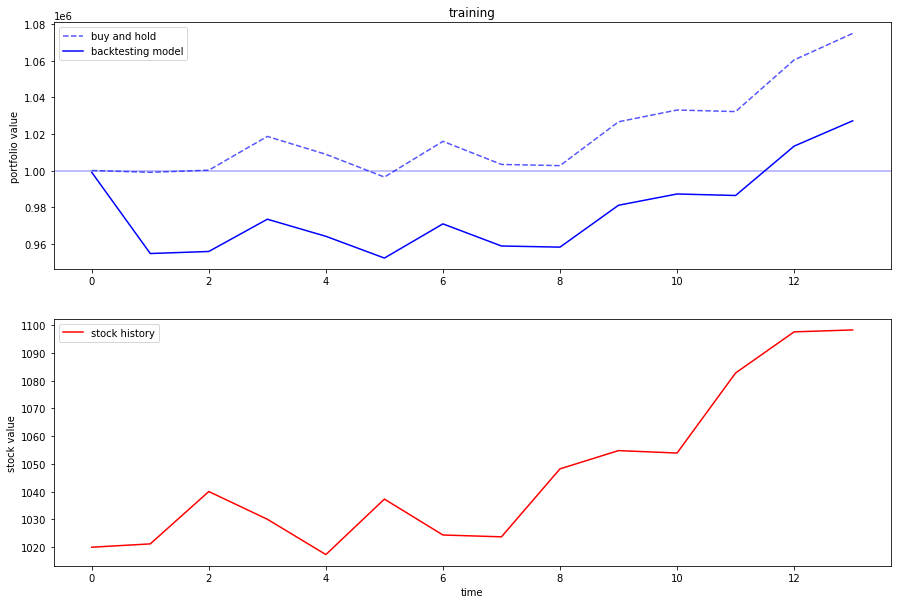

In [47]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(history[i]['model'], 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.set_title('training')
ax1.legend()

ax2.plot(history[i]['stock'], 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

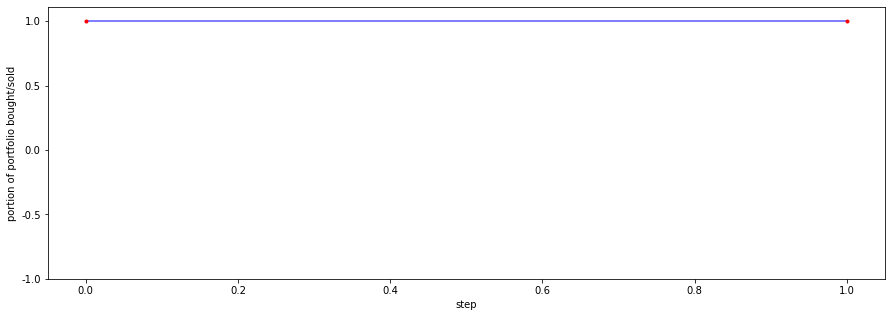

In [42]:
plt.figure(figsize=(15,5))
plt.plot(history[i]['actions'], 'b-', alpha=0.6667)
plt.plot(history[i]['actions'], 'r.')

plt.yticks(np.arange(dqn_solver.action_space), np.linspace(-1,1, dqn_solver.action_space))
plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')
plt.show();

In [33]:
rewards = np.array([history[i]['rewards'] for i in np.arange(len(history))])

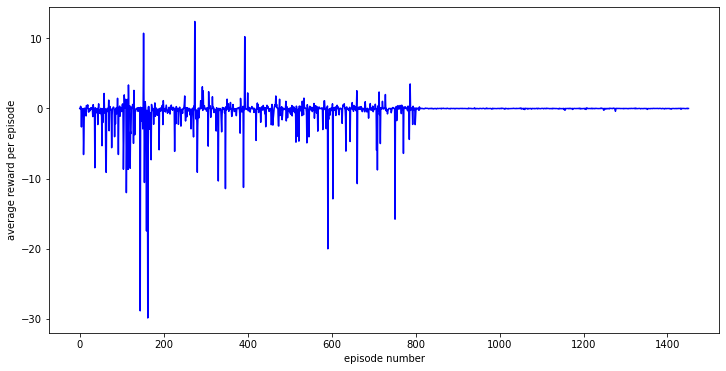

In [43]:
plt.figure(figsize=(12,6))
plt.plot(rewards, 'b-')
plt.xlabel('episode number')
plt.ylabel('average reward per episode')
plt.show();

In [44]:
print(corr(history[i]['stock'], history[i]['actions']))

nan


---

In [49]:
pickle_model(dqn_solver, path='model_info_goog_3')

INFO:tensorflow:Assets written to: model_info_goog_3\network.pb\assets


INFO:tensorflow:Assets written to: model_info_goog_3\network.pb\assets
